# Veri Hikayesi Anlatımı

In [130]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [131]:
xls = pd.read_excel('elektrik_veri.xls')

In [132]:
excel_file_obj = pd.ExcelFile('elektrik_veri.xls')
print("Sayfa isimleri:", excel_file_obj.sheet_names)

Sayfa isimleri: ['Tahsilat', 'Tahsilat 1', 'Tahakkuk', 'Tahakkuk 1', 'Tahakkuk 2']


In [133]:
# Her sayfayı ayrı DataFrame'e yükle
df_tahsilat = pd.read_excel(excel_file_obj, sheet_name='Tahsilat')
df_tahsilat_1 = pd.read_excel(excel_file_obj, sheet_name='Tahsilat 1')
df_tahakkuk = pd.read_excel(excel_file_obj, sheet_name='Tahakkuk') # Hamamözü
df_tahakkuk_1 = pd.read_excel(excel_file_obj, sheet_name='Tahakkuk 1') # Gümüşhacıköy
df_tahakkuk_2 = pd.read_excel(excel_file_obj, sheet_name='Tahakkuk 2') # Göynücek

İlçe Karşılaştırma
Analizi:
İlçeler arası tüketim farklılıklarını açıklayan faktörleri araştırın (hesap sınıfı dağılımı, mevsimsellik, müşteri
profili...). Bulgularınızı görsel bir rapor halinde sunun.


Senaryo: Bölgesel bir elektrik dağıtım şirketinin Strateji Departmanındasınız. Şirket, altyapı yatırımlarını optimize etmek ve kayıp-kaçak oranlarını düşürmek istiyor. Yönetim kurulu sizden, ilçelerin tüketim davranışlarını analiz ederek, her ilçe için özelleştirilmiş bir operasyon stratejisi belirlemenizi istedi.

1. Görsel Analiz Özeti
Aşağıdaki grafiklerde, verisetinde yer alan 3 ana ilçe (Gümüşhacıköy, Göynücek, Hamamözü) için gerçekleştirdiğim derinlemesine analizin çıktılarını görebilirsiniz:

Grafik 1 (Sol Üst): İlçelerin toplam tüketimi (Bar) ve abone başına düşen ortalama tüketim yoğunluğu (Kırmızı Çizgi).

Grafik 2 (Sağ Üst): Müşteri profili dağılımı. Hangi ilçe "Konut", hangisi "Tarım" ağırlıklı?

Grafik 3 (Alt): Mevsimsel dalgalanmalar. Tüketimin zaman içindeki değişimi.

In [134]:
df_list = [df_tahakkuk, df_tahakkuk_1, df_tahakkuk_2]
df_accrual = pd.concat(df_list, ignore_index=True)

In [135]:
# 2. VERİ TEMİZLEME & ÖN İŞLEME
# Sütun isimlerini standartlaştırma (küçük harf, boşluk yerine _)
df_accrual.columns = [c.lower().replace(' ', '_') for c in df_accrual.columns]

In [136]:
# Sayısal dönüşümler
df_accrual['kwh'] = pd.to_numeric(df_accrual['kwh'], errors='coerce')
df_accrual.dropna(subset=['kwh'], inplace=True) # Boş tüketim verisini at

In [137]:
# Tarih formatlama (Aylık trend analizi için)
df_accrual['fatura_tarihi'] = pd.to_datetime(df_accrual['fatura_tarihi'], errors='coerce')
df_accrual['month_year'] = df_accrual['fatura_tarihi'].dt.to_period('M')

In [138]:
# İlçe isimlerini standartlaştırma (Büyük harf)
if 'ilce' in df_accrual.columns:
    df_accrual['ilce'] = df_accrual['ilce'].astype(str).str.upper()

In [139]:
# A. Tüketim Yoğunluğu Analizi
# Hangi ilçe daha verimli/yoğun tüketiyor? (Toplam Tüketim / Abone Sayısı)
district_total = df_accrual.groupby('ilce')['kwh'].sum()
district_users = df_accrual.groupby('ilce')['sozlesme_hesap_no'].nunique()
district_intensity = (district_total / district_users).sort_values(ascending=False)

In [140]:
# B. Müşteri Profili Analizi (Hesap Sınıfı)
# İlçenin karakteri ne? Tarım mı, Konut mu?
target_col = 'hesap_sınıfı' if 'hesap_sınıfı' in df_accrual.columns else 'hesap_sinifi'
district_profile = df_accrual.groupby(['ilce', target_col])['kwh'].sum().unstack().fillna(0)
# Yüzdesel hale getirme
district_profile_pct = district_profile.div(district_profile.sum(axis=1), axis=0) * 100

In [141]:
# C. Mevsimsellik Analizi
monthly_trend = df_accrual.groupby(['month_year', 'ilce'])['kwh'].sum().reset_index()
monthly_trend['month_year'] = monthly_trend['month_year'].astype(str)

In [142]:
# --- 4. GÖRSELLEŞTİRME ---
plt.figure(figsize=(18, 12))

<Figure size 1800x1200 with 0 Axes>

<Figure size 1800x1200 with 0 Axes>

/tmp/ipython-input-3350651747.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax1 = sns.barplot(x=district_total.index, y=district_total.values, palette='viridis')


Text(0, 0.5, 'Ortalama Tüketim (Kırmızı Çizgi)')

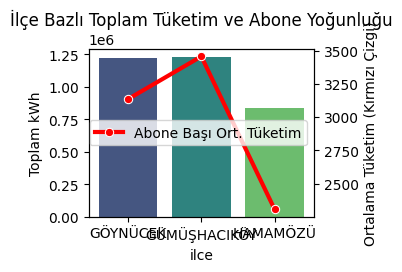

In [143]:
# Grafik 1: Yoğunluk
plt.subplot(2, 2, 1)
ax1 = sns.barplot(x=district_total.index, y=district_total.values, palette='viridis')
plt.title('İlçe Bazlı Toplam Tüketim ve Abone Yoğunluğu')
plt.ylabel('Toplam kWh')
ax2 = ax1.twinx() # İkinci eksen
sns.lineplot(x=district_intensity.index, y=district_intensity.values, ax=ax2, color='red', marker='o', linewidth=3, label='Abone Başı Ort. Tüketim')
ax2.set_ylabel('Ortalama Tüketim (Kırmızı Çizgi)')

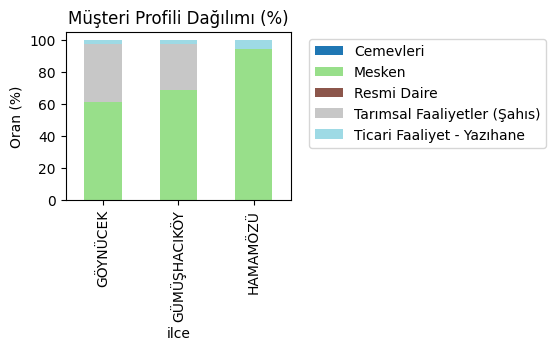

In [144]:
# Grafik 2: Müşteri Profili (Yığılmış Bar)
plt.subplot(2, 2, 2)
district_profile_pct.plot(kind='bar', stacked=True, ax=plt.gca(), colormap='tab20')
plt.title('Müşteri Profili Dağılımı (%)')
plt.ylabel('Oran (%)')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

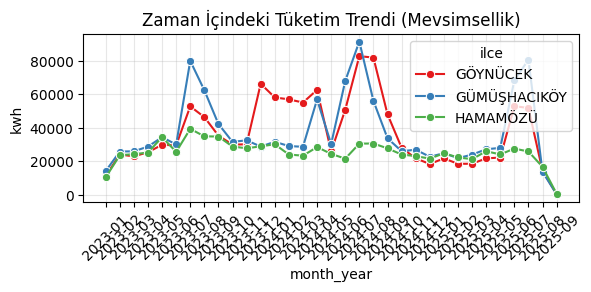

In [145]:
# Grafik 3: Trend
plt.subplot(2, 1, 2)
sns.lineplot(data=monthly_trend, x='month_year', y='kwh', hue='ilce', marker='o', palette='Set1')
plt.title('Zaman İçindeki Tüketim Trendi (Mevsimsellik)')
plt.xticks(rotation=45)
plt.grid(True, alpha=0.3)

In [146]:
plt.tight_layout()
plt.show()

<Figure size 640x480 with 0 Axes>

Analiz Sonuçları:

Gümüşhacıköy:

Abone başına 3455 kWh tüketim ile bölgenin en yüksek enerji tüketimine sahiptir.

Çünkü hem konut (%68) hem de ciddi bir tarımsal (%28) tüketimi vardır.

Aksiyon: Arıza bakım ekiplerinin en dikkatinde olan yer olmalıdır. Kesinti maliyeti  en yüksek va bu yüzden ticari kayıp en yüksek olabilecek bölgedir.

Göynücek:

Tüketiminin %36.5'i tarımsaldır. Bu oran Hamamözü'nde neredeyse sıfırdır.

Çünkü ilçe geçimini tarımdan sağladığı için sulama ve sulama pompası için tüketim fazla olacaktır.

Mayıs-Eylül ayları arasında bu ilçedeki trafoların yük kapasiteleri artırılmalıdır. Kışın ise bakım için ideal zamandır.

Hamamözü:

Tüketimin %94.5'i konuttur.

Çünkü ticari veya endüstriyel bir faaliyet sınırlıdır.

Bu bölgede sayaç kontrolleri yapılabilir. Tüketim durumu çok düzenli olduğu için kaçak kullanımları tespit etmek kolaydır

---Müşteri Segmentasyonu:---

Tüketim miktarı ve ödeme davranışına göre müşterileri 3-4 gruba ayırın. Her grubun karakteristiklerini
tanımlayın ve iş önerileri gel


In [147]:
# Tüketim Verilerini Birleştirme
# 3 ayrı ilçenin tahakkuk verisini tek bir 'df_tuketim_hepsi' tablosunda alt alta topluyoruz.
df_tuketim_hepsi = pd.concat([df_tahakkuk, df_tahakkuk_1, df_tahakkuk_2], ignore_index=True)

In [148]:
# Sütun isimlerini temizleyelim
df_tuketim_hepsi.columns = df_tuketim_hepsi.columns.str.strip().str.lower().str.replace(' ', '_')

df_tahsilat_1.columns = df_tahsilat_1.columns.str.strip()

In [149]:
# Hesaplamalar

# Müşteri Başına Ortalama Tüketim
# 'sozlesme_hesap_no' sütununa göre gruplayıp 'kwh' ortalamasını alıyoruz.
grp_tuketim = df_tuketim_hepsi.groupby('sozlesme_hesap_no')['kwh'].mean().reset_index()
grp_tuketim.rename(columns={'kwh': 'ortalama_tuketim'}, inplace=True)

In [150]:
# Ödeme Davranışı Hesapla (df_tahsilat_1)
# Zamanında ve geç ödenen verileri ayırt eder.
# Zamanında ödenen sütunlar
cols_zamaninda = ['Son Ödeme Tarihinden Önceki Tahsilat', 'Son Ödeme Tarihindeki Tahsilat']
# Geç ödenen sütunlar ("Son Ödeme (" ile başlayanlar)
cols_gec = [c for c in df_tahsilat_1.columns if str(c).startswith("Son Ödeme (")]

In [151]:
# Boş verileri 0 ile dolduralım.
df_tahsilat_1[cols_zamaninda + cols_gec] = df_tahsilat_1[cols_zamaninda + cols_gec].fillna(0)

In [152]:

df_tahsilat_1['tutar_gec'] = df_tahsilat_1[cols_gec].sum(axis=1)
df_tahsilat_1['toplam_tahsilat'] = df_tahsilat_1[cols_zamaninda].sum(axis=1) + df_tahsilat_1['tutar_gec']

In [153]:
# Gecikme Oranı = Geç Ödenen / Toplam Ödenen
# 0'a yakınsa -> İyi Müşteri
# 1'e yakınsa -> Kötü Müşteri
df_tahsilat_1['gecikme_orani'] = df_tahsilat_1['tutar_gec'] / df_tahsilat_1['toplam_tahsilat']

In [154]:
# Müşteri bazında özet:
grp_odeme = df_tahsilat_1.groupby('Söz.hsp.(bağımsız)')['gecikme_orani'].mean().reset_index()
grp_odeme.rename(columns={'Söz.hsp.(bağımsız)': 'sozlesme_hesap_no'}, inplace=True)

In [155]:
# Final Tablo ve Segmentasyon

# Tüketim ve Ödeme bilgilerini müşteri numarasına göre birleştirelim
df_final = pd.merge(grp_tuketim, grp_odeme, on='sozlesme_hesap_no', how='inner')

In [156]:
# Eşik Değerler
ESIK_TUKETIM = 50   # 50 kWh üstü çok tüketen kabul edilsin
ESIK_GECIKME = 0.10 # %10'dan fazla gecikme sorunlu kabul edilsin

In [157]:
def segment_belirle(row):
    cok_harciyor = row['ortalama_tuketim'] > ESIK_TUKETIM
    duzenli_oduyor = row['gecikme_orani'] < ESIK_GECIKME

    if cok_harciyor and duzenli_oduyor:
        return "1. Değerli Müşteri"
    elif cok_harciyor and not duzenli_oduyor:
        return "2. Takip Gerektiren (Büyüme)"
    elif not cok_harciyor and duzenli_oduyor:
        return "3. Standart Müşteri"
    else:
        return "4. Sorunlu/Maliyetli"

In [158]:
df_final['Segment'] = df_final.apply(segment_belirle, axis=1)

In [159]:
# Sonuçlar
print("\n--- SEGMENTASYON SONUÇLARI ---")
print(df_final['Segment'].value_counts())


--- SEGMENTASYON SONUÇLARI ---
Segment
1. Değerli Müşteri              271
3. Standart Müşteri             244
4. Sorunlu/Maliyetli            136
2. Takip Gerektiren (Büyüme)    112
Name: count, dtype: int64


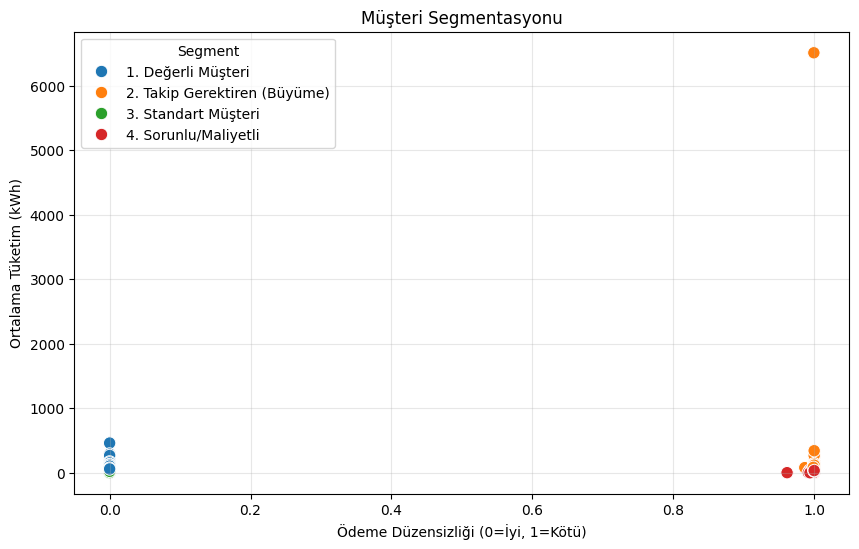

In [160]:
# Grafik
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df_final, x='gecikme_orani', y='ortalama_tuketim', hue='Segment', s=80)
plt.title('Müşteri Segmentasyonu')
plt.xlabel('Ödeme Düzensizliği (0=İyi, 1=Kötü)')
plt.ylabel('Ortalama Tüketim (kWh)')
plt.grid(True, alpha=0.3)
plt.show()

3. Bonus Senaryo

Yapılan  analiz sonucunda tahsilat sürecindeki darboğazların belirli ilçe ve müşterilerde yoğunlaştığını göstermektedir. Şirketin nakit akışını iyileştirmesi için bir strateji geliştirilmesi gereklidir.

Teşhisler
A. En Riskli İlçe: Gümüşhacıköy (%42 Gecikme Oranı)

Gümüşhacıköy, en yüksek tüketim yoğunluğuna sahip ilçe olmasına rağmen, tahakkuk eden her 100 TL'nin 42 TL'si vadesinde ödenmemektedir.

Bu ilçe, şirketin zarar ettiği bir ilçedir. Bu zarar oranı Hamamözü (%25) ile kıyaslandığında zarar neredeyse iki katıdır. Buradaki sorunun operasyonel değil, yapısal olduğu görülmektedir.

B. Alarm Veren Sektörler: "Kamu ve Tarım" Analiz, gecikmelerin bireysel abonelerden çok kurumsal yapılardan kaynaklandığını göstermektedir.

Belediye & Karayolları Aydınlatma (%100 Gecikme)
Tarımsal Sulama Kooperatifleri (%93 Gecikme)
Sanayi (%90 Gecikme): Sanayi abonelerinin bu kadar yüksek gecikme oranına sahip olması kritik bir risk göstergesidir.

C. Kronikleşen Borçlar

İbadethaneler ve Tarımsal Kooperatiflerödeme gücü eksikliğine bağlı olarak borçlarını geç ödemektedirler.

3. Veri Destekli Çözüm Önerileri


Aksiyon 1: Tarım Sektörü İçin

Göynücek ve Gümüşhacıköy'deki tarımsal aboneler için son ödeme tarihini "Hasat Dönemi"ne) endeksleyen özel bir kampanya yapılmalıdır. Bu, gecikme faizini baştan fiyatlandırarak tahsilat garantisi sağlar.


Aksiyon 2: Kamu Mahsuplaşma Protokolü

Sorun: Aydınlatma ödemeleri %100 gecikmeli.

Çözüm: Belediyelerden ödemeyi beklemek yerine borç takası nakit akışını rahatlatır.

Aksiyon 3: Gümüşhacıköy Odaklı Operasyon

Sorun: %42'lik devasa kaçak/gecikme oranı.

Çözüm: Şirketin tahsilat ekipleri ilçeyi dikkate almalılardır. Bu bölgede ödeme noktasına uzak köylerde yerinde tahsilat yapılmalıdır.

Aksiyon 4: Sanayi Aboneleri İçin Erken Uyarı

Sorun: Sanayide %90 risk bulunmaktadır.

Çözüm: Yüksek tüketimli sanayi aboneleri için "Fatura Kesiminden sonra tahsilatı sağlayacak tahsilat ekibi kurulmalıdır.

Bu stratejilerle, özellikle Gümüşhacıköy ve Tarım sektöründen kaynaklanan nakit akışı tıkanıklığının 3-6 ay içinde %15-20 oranında iyileştirilebilecektir.

Analiz sonuçlarını özetleyen görsel rapor aşağıdadır:

Grafik 1 (Sol Üst): Müşteri sınıflarına göre gecikme riski.

Grafik 2 (Sağ Üst): Hangi ilçe ödemede en çok zorlanıyor?

Grafik 3 (Alt): Riskin zamana yayılımı.

In [161]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [162]:
file_path = 'elektrik_veri.xls'
# Sadece tahsilat verisiyle ilgileniyoruz
df_payment = pd.read_excel(file_path, sheet_name='Tahsilat 1')

In [163]:
# NaN (Boş) değerleri 0 ile dolduruyoruz.
df_payment = df_payment.fillna(0)

In [164]:
# Gecikme Sütunlarını Tespit Etme
# "Son Ödeme (1)", "Son Ödeme (2)" vb. sütunlar gecikmeleri ifade eder.
late_cols = [col for col in df_payment.columns if 'Son Ödeme (' in col]

In [165]:
# Kritik/Kronik Gecikme Sütunları (>30 Gün Gecikenler)
gecikme_cols = [col for col in late_cols if any(x in col for x in ['30-60', '60-90', '90-120', '120-150', '150-180', '180+'])]

In [166]:
# METRİK HESAPLAMA (KPIs)
df_payment['toplam_gecikme_tutari'] = df_payment[late_cols].sum(axis=1)
df_payment['kronik_gecikme_tutari'] = df_payment[gecikme_cols].sum(axis=1)

In [167]:
# Analiz tablolarını oluşturmak için gruplama
df_active = df_payment[df_payment['Tahakkuk Tutar'] > 0].copy()

In [168]:
# İLÇE BAZLI RİSK ANALİZİ
risk_district = df_active.groupby('İlçe').agg({
    'Tahakkuk Tutar': 'sum',
    'toplam_gecikme_tutari': 'sum'
}).reset_index()

In [169]:
risk_district['gecikme_orani'] = (risk_district['toplam_gecikme_tutari'] / risk_district['Tahakkuk Tutar']) * 100
risk_district = risk_district.sort_values(by='gecikme_orani', ascending=False)

In [170]:
# MÜŞTERİ SINIFI BAZLI RİSK ANALİZİ
risk_class = df_active.groupby('Hesap Sınıfı').agg({
    'Tahakkuk Tutar': 'sum',
    'toplam_gecikme_tutari': 'sum',
    'kronik_gecikme_tutari': 'sum'
}).reset_index()

In [171]:
risk_class['gecikme_orani'] = (risk_class['toplam_gecikme_tutari'] / risk_class['Tahakkuk Tutar']) * 100
risk_class['kronik_risk_orani'] = (risk_class['kronik_gecikme_tutari'] / risk_class['Tahakkuk Tutar']) * 100

In [172]:
# En riskli ilk 10 sınıf:
risk_class_top10 = risk_class.sort_values(by='gecikme_orani', ascending=False).head(10)

In [173]:
# DÖNEMSEL TREND ANALİZİ
tr_months = {'OCK': '01', 'SUB': '02', 'MRT': '03', 'NIS': '04', 'MAY': '05', 'HAZ': '06',
             'TEM': '07', 'AGU': '08', 'EYL': '09', 'EKI': '10', 'KAS': '11', 'ARA': '12'}

In [174]:
def parse_date(date_str):
    try:
        parts = str(date_str).split() # "OCK 2023" -> ["OCK", "2023"]
        if len(parts) == 2:
            month_num = tr_months.get(parts[0].upper(), '01')
            return f"{parts[1]}-{month_num}" # "2023-01" formatına çevir
        return date_str
    except:
        return date_str

In [175]:
df_active['tarih_format'] = df_active['Mali yıl/dönem'].apply(parse_date)

risk_trend = df_active.groupby('tarih_format').agg({
    'Tahakkuk Tutar': 'sum',
    'toplam_gecikme_tutari': 'sum'
}).reset_index()
risk_trend['gecikme_orani'] = (risk_trend['toplam_gecikme_tutari'] / risk_trend['Tahakkuk Tutar']) * 100
risk_trend = risk_trend.sort_values('tarih_format') # Kronolojik sırala

In [176]:
# GÖRSELLEŞTİRME VE RAPORLAMA
plt.figure(figsize=(18, 12))

<Figure size 1800x1200 with 0 Axes>

<Figure size 1800x1200 with 0 Axes>

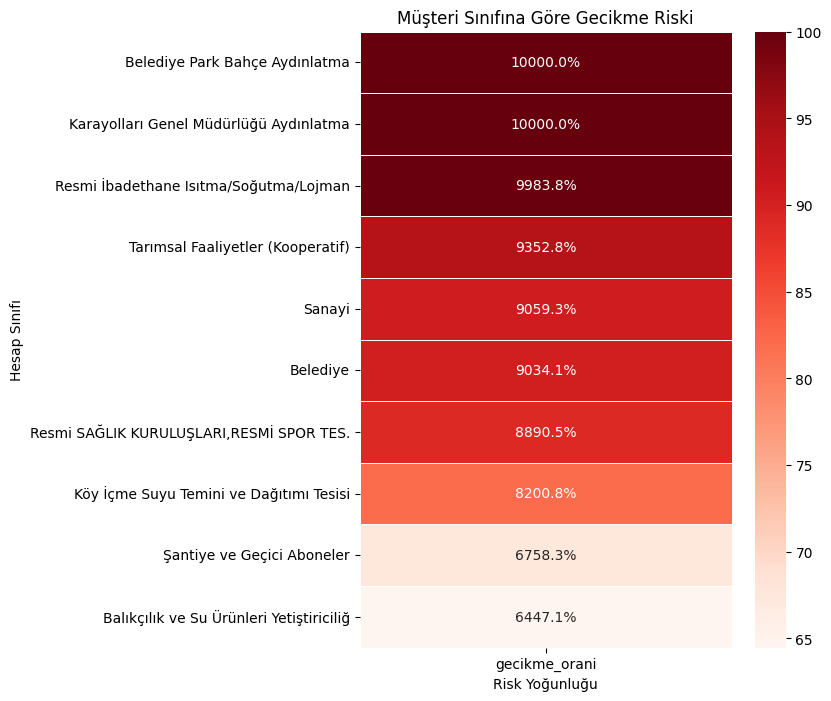

In [177]:
#Heatmap
heatmap_data = risk_class_top10.set_index('Hesap Sınıfı')[['gecikme_orani']]

# Gecikme oranına göre çoktan aza sıralayalım ki en kırmızılar üstte olsun
heatmap_data = heatmap_data.sort_values(by='gecikme_orani', ascending=False)

# 2. Çizim
plt.figure(figsize=(6, 8)) # Dikey bir yapı daha okunaklı olur
sns.heatmap(heatmap_data,
            annot=True,      # Kutuların içine sayıları yaz
            fmt=".1%",       # Yüzdelik format (Örn: %30.5)
            cmap="Reds",     # Renk paleti (Kırmızı tonları)
            cbar=True,       # Yan tarafa renk skalası koy
            linewidths=.5)   # Kutular arası boşluk

plt.title('Müşteri Sınıfına Göre Gecikme Riski')
plt.ylabel('Hesap Sınıfı')
plt.xlabel('Risk Yoğunluğu')

plt.show()

/tmp/ipython-input-3843450880.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=risk_district, x='İlçe', y='gecikme_orani', palette='Oranges_r')


Text(0, 0.5, 'Geç Ödeme Oranı (%)')

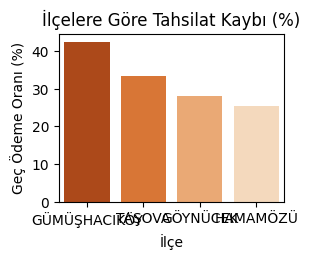

In [178]:
# Grafik 2
plt.subplot(2, 2, 2)
sns.barplot(data=risk_district, x='İlçe', y='gecikme_orani', palette='Oranges_r')
plt.title('İlçelere Göre Tahsilat Kaybı (%)')
plt.ylabel('Geç Ödeme Oranı (%)')

Text(0.5, 1.0, 'Toplam Risk vs. Kronik Risk (>30 Gün)')

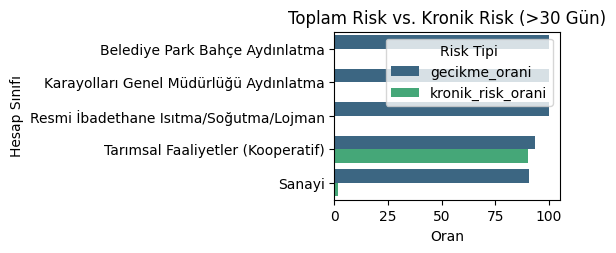

In [179]:
# Grafik 3
plt.subplot(2, 2, 3)
df_melt = risk_class_top10.head(5).melt(
    id_vars='Hesap Sınıfı',
    value_vars=['gecikme_orani', 'kronik_risk_orani'],
    var_name='Risk Tipi',
    value_name='Oran'
)
sns.barplot(data=df_melt, x='Oran', y='Hesap Sınıfı', hue='Risk Tipi', palette='viridis')
plt.title('Toplam Risk vs. Kronik Risk (>30 Gün)')

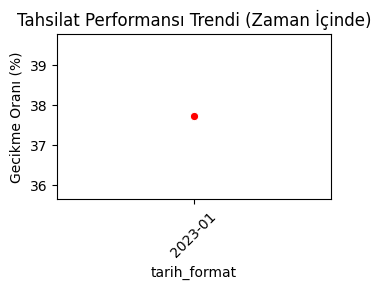

In [180]:
# Grafik 4
plt.subplot(2, 2, 4)
sns.lineplot(data=risk_trend, x='tarih_format', y='gecikme_orani', marker='o', color='red')
plt.title('Tahsilat Performansı Trendi (Zaman İçinde)')
plt.xticks(rotation=45)
plt.ylabel('Gecikme Oranı (%)')

plt.tight_layout()
plt.show()

In [181]:
# ÖZET METRİKLER
print("--- İLÇE BAZLI RİSK TABLOSU ---")
print(risk_district[['İlçe', 'gecikme_orani']])
print("\n--- EN RİSKLİ 5 MÜŞTERİ GRUBU ---")
print(risk_class_top10[['Hesap Sınıfı', 'gecikme_orani']].head())

--- İLÇE BAZLI RİSK TABLOSU ---
           İlçe  gecikme_orani
1  GÜMÜŞHACIKÖY      42.368065
3        TAŞOVA      33.226861
0      GÖYNÜCEK      27.940302
2      HAMAMÖZÜ      25.461324

--- EN RİSKLİ 5 MÜŞTERİ GRUBU ---
                              Hesap Sınıfı  gecikme_orani
3           Belediye Park Bahçe Aydınlatma     100.000000
9   Karayolları Genel Müdürlüğü Aydınlatma     100.000000
18  Resmi İbadethane Isıtma/Soğutma/Lojman      99.837662
21       Tarımsal Faaliyetler (Kooperatif)      93.528232
19                                  Sanayi      90.593365
